## Approximation of the Koopman operator for the OU process using 1D Gaussian basis functions

In [1]:
# Import the required libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import jax
import jax.numpy as jnp
import importlib

import systems
import optimal_koopman
importlib.reload(optimal_koopman)
from optimal_koopman import get_rcparams, psi_1D, sortEig, basis_func_1D, OptimalKoopmanParameter
from systems import EulerMaruyamaData
plt.rcParams.update(get_rcparams())

jax.config.update("jax_enable_x64", True)

## OU process data

In [2]:
# Parameters to generate data for the OU process using the Euler-Maruyama scheme

evs = 5              # Number of dominant eigenvalues and eigenfunctions to be approximated

h_em = 1e-3             # Step size for E-M

iters = 500          # Iterations in E-M

alpha = 1                # Drift coefficient

beta_ou = 4              # Inverse temperature

m_ou = 5000              # Number of data points

X_ou = np.random.uniform(-2, 2, size=(1, m_ou))          # Data points in x       

data = EulerMaruyamaData(m_ou, X_ou, h_em, iters)      # Calling Euler-Maruyama class 

Y_ou = data.get_ou_data(beta_ou, alpha)                # Data points in y

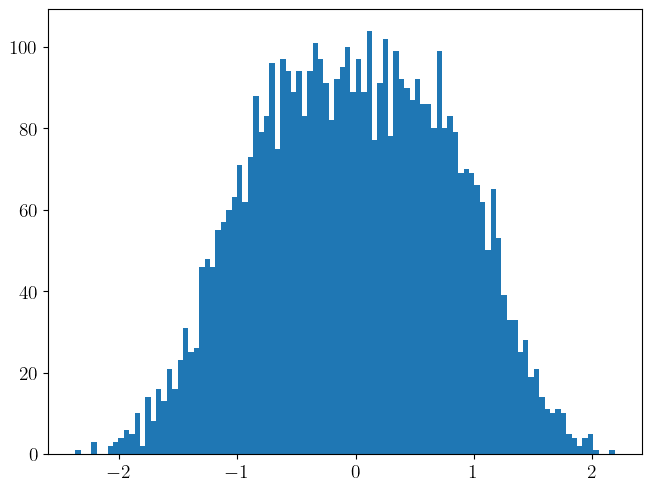

In [3]:
# Density of the data

plt.figure()
plt.hist(Y_ou.T, bins=100)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('ou_density_hist.pdf')
plt.show()

In [4]:
# Analytically calculated eigenvalues and eigenfunctions of the Koopman operator for the OU process

i = np.array([0,1,2,3,4])                        # Exact eigenvalues for lag time = 0.5 
Exact_EV = np.array(np.exp(-i*0.5))


def true_eigf_ou(x, i):
    if i == 0:                                          # Exact eigenfunctions (Hermite polynomials)
        return np.ones(x.shape[1])
    if i == 1:
        return 2*x
    if i == 2:
        return (4*x**2 - 1)/np.sqrt(2)
    if i == 3:
        return (8*x**3 - 6*x)/np.sqrt(6)
    if i == 4:
        return (16*x**4 - 24*x**2 + 3)/np.sqrt(24)

In [5]:
# Basis functions parameters

n1 = 12
n2 = 2
n = n1 + n2                                                        # Number of basis functions 
c1 = jnp.linspace(-2, 0, n1)
c2 = jnp.linspace(0, 2, n2)                                        
C = jnp.hstack((c1, c2))                                           # Centers of the basis functions

sigmas = 0.2*jnp.ones(C.shape)                                      # Initial bandwidth
K_init = jnp.zeros((C.shape[0], C.shape[0]))                        # Initial K matrix
epss = 1e-2
loops = 1000                                                        # Number of iterations of GD
W_init = jnp.c_[sigmas, C]

psi_x_ou = psi_1D(X_ou, W_init)                                     # Transform data using initial basis
psi_y_ou = psi_1D(Y_ou, W_init)

# Calculate step-size for GD

D = psi_x_ou @ psi_x_ou.T                         # D is the hessian
e = np.linalg.eig(D)                            # eigenvalues and eigenvectors of hessian 
L = np.max(e[0])                                # e[0] is the array of eigenvalues and L is maximum eigenvalue
hk = np.real(1/L)
hw = hk

# Approximate the optimal K matrix and basis parameters using alternating gradient descent-based algorithms

optimal_K_W = OptimalKoopmanParameter(epss, loops, psi_1D)                 # Initialize the class

## Optimizing K and W using alternating gradient descent-based algorithms

In [6]:
# GD

K_gd, W_gd, loss_k_gd, loss_w_gd = optimal_K_W.koopman_approximation(K_init, W_init, X_ou, Y_ou, hk, hw, optim='gd')

# SGD

K_sgd, W_sgd, loss_k_sgd, loss_w_sgd = optimal_K_W.koopman_approximation(K_init, W_init, X_ou, Y_ou, hk, hw, optim='sgd', stochastic=True, batch_size=1000)

# Nesterov

K_nest, W_nest, loss_k_nest, loss_w_nest = optimal_K_W.koopman_approximation(K_init, W_init, X_ou, Y_ou, hk, hw, optim='nesterov')

# Adam

K_adam, W_adam, loss_k_adam, loss_w_adam = optimal_K_W.koopman_approximation(K_init, W_init, X_ou, Y_ou, hk=0.01, hw=0.01, optim='adam')


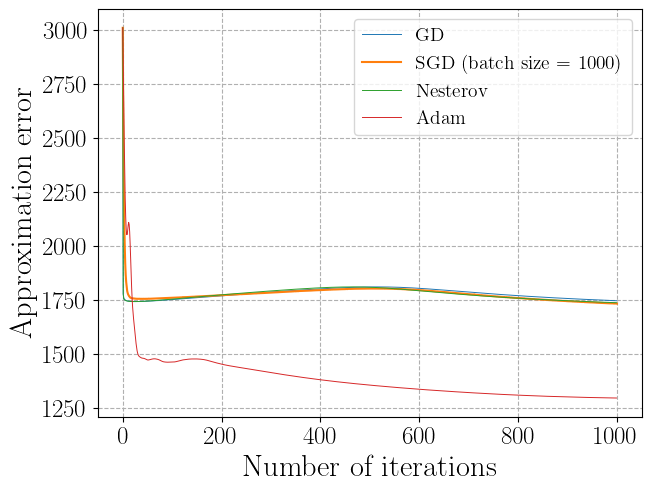

In [7]:
# plot loss in approximating K matrix

plt.figure()
plt.plot(loss_k_gd, linewidth=0.7, label='GD')
plt.plot(loss_k_sgd, label='SGD (batch size = 1000)')
plt.plot(loss_k_nest, linewidth=0.7, label='Nesterov')
plt.plot(loss_k_adam,  linewidth=0.7, label='Adam')
plt.ylabel('Approximation error', fontsize=22)
plt.xlabel('Number of iterations', fontsize=22)
plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig('loss_K_ou.pdf')
plt.show()

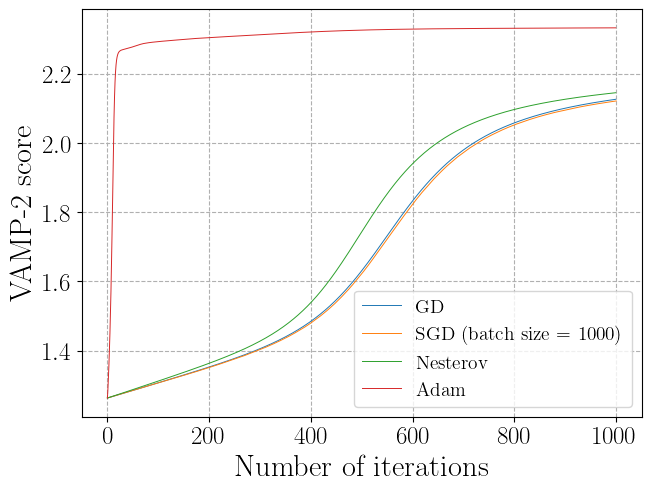

In [8]:
# plot loss in approximating K matrix

plt.figure()
plt.plot(np.abs(loss_w_gd), linewidth=0.7, label='GD')
plt.plot(np.abs(loss_w_sgd), linewidth=0.7, label='SGD (batch size = 1000)')
plt.plot(np.abs(loss_w_nest), linewidth=0.7, label='Nesterov')
plt.plot(np.abs(loss_w_adam), linewidth=0.7, label='Adam')
plt.ylabel('VAMP-2 score', fontsize=22)
plt.xlabel('Number of iterations', fontsize=22)
plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig('loss_vamp_ou.pdf')
plt.show()

In [ ]:
# Reconstruction error before the optimization

K_b = (psi_y_ou @ np.linalg.pinv(psi_x_ou)).T
error_b = optimal_K_W.cost_edmd(K_b, W_init, X_ou, Y_ou)
print('Reconstruction error before optimization: ', error_b)

# Reconstruction error after the optimization

psi_x_ou_a = psi_1D(X_ou, W_adam)
psi_y_ou_a = psi_1D(Y_ou, W_adam)
K_a = (psi_y_ou_a@np.linalg.pinv(psi_x_ou_a)).T
error_a = optimal_K_W.cost_edmd(K_a, W_adam, X_ou, Y_ou)
print('Reconstruction error after optimization: ', error_a)

1716.4429190738074
1293.9320046829005


In [12]:
# Eigendecomposition of the Koopman matrices

d_a, V_a = sortEig(np.array(K_adam))
d_b, V_b = sortEig(np.array(K_b))

print('Exact eigenvalues: ', Exact_EV)
print('Eigenvalues before optimization: ', d_b)
print('Eigenvalues after optimization: ', d_a)

Exact eigenvalues:  [1.         0.60653066 0.36787944 0.22313016 0.13533528]
Eigenvalues before optimization:  [0.89106795+0.j 0.42387052+0.j 0.21260029+0.j 0.07948774+0.j
 0.06018331+0.j]
Eigenvalues after optimization:  [0.9999927 +0.j 0.61401912+0.j 0.36704344+0.j 0.22237095+0.j
 0.12958319+0.j]


/home/s2421480/Documents/publications/data_driven_dynamical_systems/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/s2421480/Documents/publications/data_driven_dynamical_systems/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


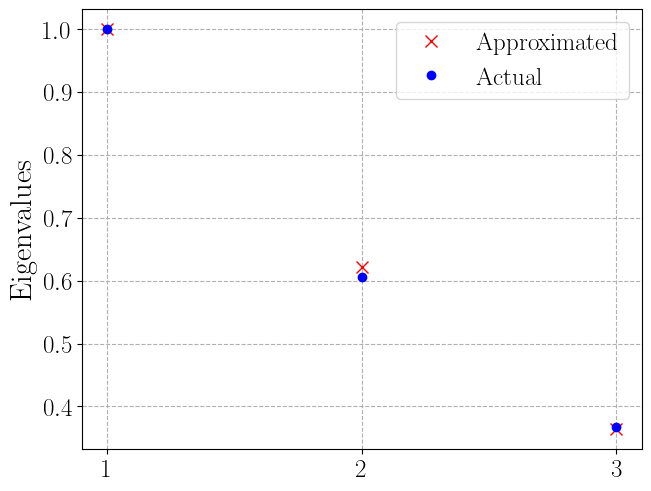

In [10]:
plt.figure()
xv = np.arange(1,4,1)
plt.plot(xv, d_a[:3], 'xr', markersize=8.0, label='Approximated')
plt.plot(xv, Exact_EV[:3], 'ob', linewidth=0.1, label='Actual')
plt.grid(which='major', linestyle='--')
plt.legend(fontsize=18)
plt.ylabel('Eigenvalues', fontsize=22)
plt.xticks(np.arange(1, 4, 1), fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig('eigv_ou.pdf')
plt.show()

In [11]:
# Calculating approximated eigenfunctions

psi_X_gd_a = psi_1D(X_ou, W_adam)
PhiX = V_a.T @ psi_X_gd_a

# Calculating analytical eigenfunctions

ExactEF_ou = np.zeros((X_ou.shape[1], 5))
for i in range(5):
    ExactEF_ou[:,i] = true_eigf_ou(X_ou,i)
    
# Making the sign of eigenfunctions same as in exact eigenfunctions

for i in range(evs):
    V_exact = true_eigf_ou(X_ou,i)
    V_1 = PhiX[i,:]
    V_2 = -PhiX[i,:]
    e1 = np.linalg.norm(V_exact-V_1)
    e2 = np.linalg.norm(V_exact-V_2)
    if e1 > e2:
        PhiX = PhiX.at[i,:].set(-PhiX[i,:])    

In [12]:
# data_ou = sio.loadmat("data_ou.mat")
# ExactEF_ou = data_ou["ExactEF_ou"]
# PsiX_gd_a = data_ou["PsiX_gd_a"]
# X_ou = data_ou["X_ou"]

/home/s2421480/Documents/publications/data_driven_dynamical_systems/.venv/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


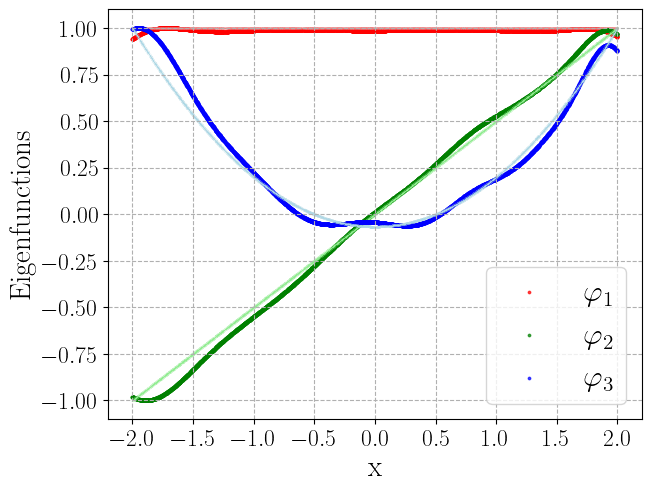

In [13]:
# Visualize the eigenfunctions

plt.figure()
colors = ['r', 'g', 'b']  
markers_exact = ['x', 'x', 'x']  
markers_approx = ['o', 'o', 'o']  
light_colors = ['lightcoral', 'lightgreen', 'lightblue'] 

for i in range(3):
    r1 = ExactEF_ou[:, i]
    r1 = r1 / np.amax(abs(r1))
    r2 = PhiX[i, :] 
    r2 = r2 / np.amax(abs(r2))
    
    plt.scatter(X_ou, r2, s=3, color=colors[i], marker=markers_approx[i], label=r"$\varphi$" + f"$_{i+1}$", alpha=0.7)
    plt.scatter(X_ou, r1, s=0.02, color=light_colors[i], marker=markers_exact[i], alpha=0.7)

plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.xlabel('x', fontsize=21)
plt.ylabel('Eigenfunctions', fontsize=21)
plt.legend(fontsize=22)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.savefig('eigf_ou.pdf')
plt.show()

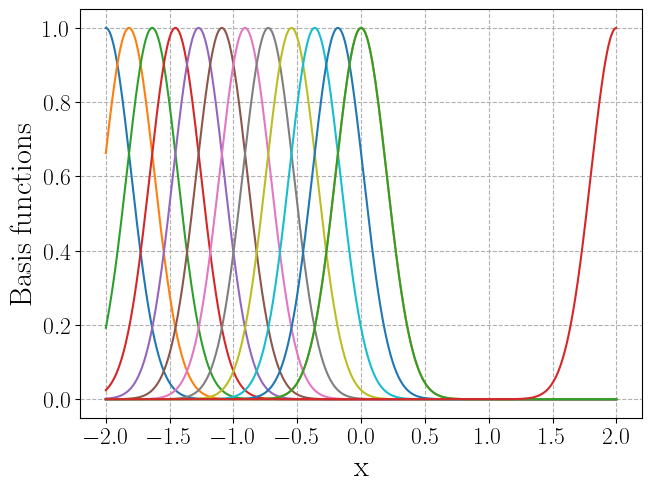

In [14]:
# Visualization of initial basis functions

# sort X values
X_ou = np.sort(X_ou)
X_new = X_ou[:, ::5]
plot_m = X_new.shape[1]

plt.figure()
for i in range(0,n):
    plt.plot(X_new.T, basis_func_1D(X_new, W_init[i, 0], W_init[i, 1]).reshape(plot_m, 1))

plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.ylabel('Basis functions', fontsize=22)
plt.xlabel('x', fontsize=22)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.savefig('Initial_basis_ou.pdf')
plt.show()


/tmp/ipykernel_17178/4279403926.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


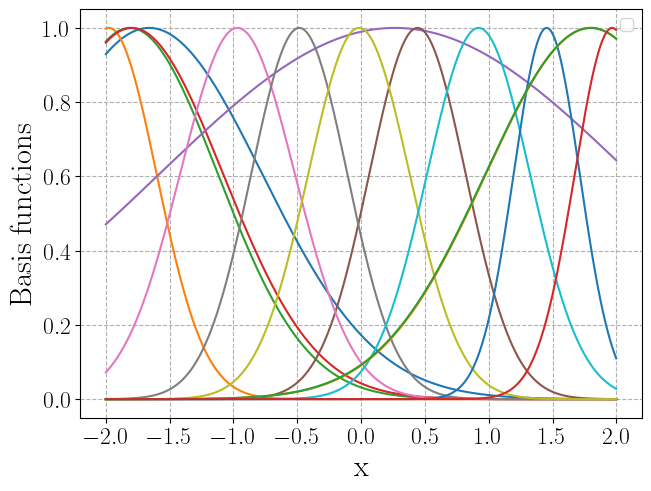

In [15]:
# Visualization of optimized basis functions  
    
plt.figure()
for i in range(0,n):
    plt.plot(X_new.T, basis_func_1D(X_new, W_adam[i, 0], W_adam[i, 1]).reshape(plot_m, 1))

plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.ylabel('Basis functions', fontsize=22)
plt.xlabel('x', fontsize=22)
plt.legend(fontsize=12)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.savefig('Final_basis_ou.pdf')
plt.show()

## Experiments with increasing basis elements

In [ ]:
# Experiment for increasing number of basis functions

nums = [10, 15, 20]
eigen_vals = np.zeros((evs, len(nums)))
# sigmas_n1 = jnp.zeros((10))
# sigmas_n2 = jnp.zeros((15))
# sigmas_n3 = jnp.zeros((20))
# cost_diff_K = []
# cost_diff_w = []

opt_k_w_exp = OptimalKoopmanParameter(1e-2, 200, psi_1D)                 # Initialize the class

for i in range(len(nums)):
    c_exp = jnp.linspace(-2, 2, nums[i])
    sigmas_exp = 0.2*jnp.ones(c_exp.shape)  
    W_init_exp = jnp.c_[sigmas_exp, c_exp]
    K_init_exp = jnp.zeros((c_exp.shape[0], c_exp.shape[0])) 
    K_exp, W_exp, loss_k_exp, loss_w_exp = opt_k_w_exp.koopman_approximation(K_init_exp, W_init_exp, X_ou, Y_ou, hk=0.01, hw=0.01, optim="adam")
    d_exp, V_exp = sortEig(np.array(K_exp))
    eigen_vals[:, i] = d_exp
    
    # cost_diff_K.append(loss_k_exp[0] - loss_k_exp[-1])
    # cost_diff_w.append(loss_w_exp[0] - loss_w_exp[-1])
    # if i == 0:
    #     sigmas_n1 = W_exp[:, 0]
    # if i == 1:
    #     sigmas_n2 = W_exp[:, 0]
    # if i == 2:
    #     sigmas_n3 = W_exp[:, 0]

# Convert the operator eigenvalues to generator eigenvalues

gen_eigv = jnp.log(eigen_vals)/0.5 
gen_exact_eigv = jnp.log(Exact_EV)/0.5

In [ ]:
colors = ['r', 'g', 'b']  
markers = ['x', '+', '*']  

plt.figure()
for i in range(len(nums)):
    plt.plot(gen_eigv[:-1, i], 'o', color=colors[i], marker=markers[i], markersize=8.0, label=f'n = {nums[i]}')
plt.plot(gen_exact_eigv[:-1], 'ob', linewidth=0.1, label='Actual')
plt.grid(which='major', linestyle='--')
plt.legend(fontsize=18)
plt.ylabel('Eigenvalues', fontsize=22)
plt.xticks(np.arange(1, 4, 1), fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig('eigv_ou.pdf')
plt.show()

In [ ]:
# Plotting error between the actual and approximated vamp score

vamp_exact = np.sum(Exact_EV)
vamp_approx = np.sum(eigen_vals, axis=0)
error_vamp = vamp_approx - vamp_exact
xv = np.array([10, 15, 20])
plt.figure()
plt.plot(xv, abs(error_vamp), 'ob', label='Difference between sum of the approximated and the actual eigenvalues')
plt.grid(which='major', linestyle='--')
plt.legend(fontsize=10, loc='lower left')
plt.ylabel('Error', fontsize=22)
plt.xlabel('Number of basis functions', fontsize=22)
plt.xticks(np.arange(10, 25, 5), fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig('eigv_ou.pdf')
plt.show()